In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import seaborn as sns

/Users/sawale/Documents/FunnyProject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# df = pd.read_parquet("/Users/sawale/Documents/FunnyProject/data/labeled_jokes.parquet")

df = pd.read_parquet("/Users/sawale/Documents/FunnyProject/data/_tmp/")
df.shape

(57, 11)

In [11]:
df.head()

,date,joke,score,humor,offensiveness,clarity,surprise_factor,relatability,novelty,conciseness,sentiment
412005,2018-08-23 13:28:10,What does a racist joke and crossing the stree...,17810.0,35.2,78.9,62.1,12.7,28.5,1.8,88.3,-45.6
161935,2016-04-15 20:04:30,I have spent the past year looking for my ex's...,2.0,65.2,12.8,88.5,45.7,35.1,22.9,91.3,-25.6
138637,2015-12-19 15:24:52,Why is. Dr.Dre's Headphones so popular? Beats me.,1.0,65.2,12.8,92.5,48.7,35.1,28.3,88.9,15.4
446460,2018-12-17 23:55:09,I wish I could be like Jesus Christ... That so...,6.0,62.5,15.0,85.0,75.0,30.0,10.0,90.0,-20.0
486819,2019-04-15 11:12:03,Why did the seagull fly over the sea? Because ...,10.0,62.5,1.2,95.0,78.3,25.0,30.0,85.0,15.0


In [14]:
from sklearn.preprocessing import StandardScaler

# Define the numerical columns to scale
numerical_columns = ['humor', 'offensiveness', 'clarity',
                     'surprise_factor', 'relatability', 'novelty',
                     'conciseness', 'sentiment']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the numerical columns and transform them
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [15]:
df.head()

,date,joke,score,humor,offensiveness,clarity,surprise_factor,relatability,novelty,conciseness,sentiment,joke_token_count
412005,2018-08-23 13:28:10,What does a racist joke and crossing the stree...,17810.0,-2.477983,3.394645,-1.820912,-2.465324,-0.190207,-1.941585,-0.042896,-1.593637,21
161935,2016-04-15 20:04:30,I have spent the past year looking for my ex's...,2.0,0.432086,-0.200982,0.290437,-0.583695,0.644751,-0.027218,0.446116,-0.827304,20
138637,2015-12-19 15:24:52,Why is. Dr.Dre's Headphones so popular? Beats me.,1.0,0.432086,-0.200982,0.610338,-0.412638,0.644751,0.462714,0.054907,0.743679,16
446460,2018-12-17 23:55:09,I wish I could be like Jesus Christ... That so...,6.0,0.170179,-0.081309,0.010523,1.086963,-0.000444,-1.197613,0.234211,-0.612731,21
486819,2019-04-15 11:12:03,Why did the seagull fly over the sea? Because ...,10.0,0.170179,-0.831984,0.810276,1.275126,-0.632988,0.616952,-0.580809,0.728353,26


# EDA on joke length

Five-Point Summary for Joke Token Counts:
min: 7
Q1: 17.0
median: 21.0
Q3: 43.0
max: 302
Percentage of documents with token counts > 512: 0.00%
Token count at 99.9th percentile: 299.25600000000014


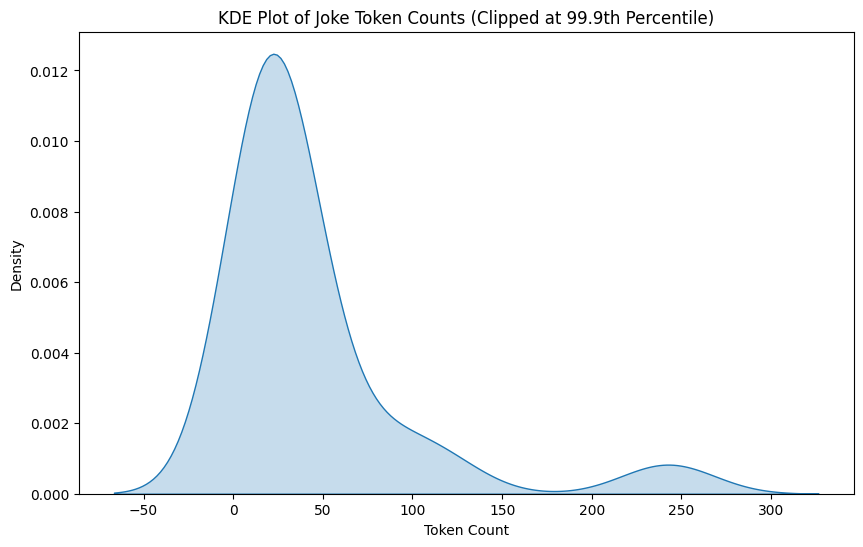

In [16]:
# Step 1: Initialize the tokenizer from Hugging Face.
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")

# Step 2: Create a new column to count the tokens in each joke.
# Here, tokenizer.tokenize(x) returns a list of tokens, and we take its length.
df['joke_token_count'] = df['joke'].apply(lambda x: len(tokenizer.tokenize(x)))

# Step 3: Compute the five-number summary for token counts.
five_point_summary = {
    'min': df['joke_token_count'].min(),
    'Q1': df['joke_token_count'].quantile(0.25),
    'median': df['joke_token_count'].median(),
    'Q3': df['joke_token_count'].quantile(0.75),
    'max': df['joke_token_count'].max()
}

print("Five-Point Summary for Joke Token Counts:")
for key, value in five_point_summary.items():
    print(f"{key}: {value}")

# Step 4: Calculate the percentage of documents with token count greater than 512.
docs_over_512 = (df['joke_token_count'] > 512).sum()
total_docs = len(df)
percentage_over_512 = (docs_over_512 / total_docs) * 100
print(f"Percentage of documents with token counts > 512: {percentage_over_512:.2f}%")

# Step 5: Determine the clip value: the 99.9th percentile of the token counts.
clip_value = df['joke_token_count'].quantile(0.999)
print(f"Token count at 99.9th percentile: {clip_value}")

# Step 6: Plot the KDE (Kernel Density Estimate) of the token count distribution.
# We filter the data to include only those documents with token counts less than or equal to clip_value.
plt.figure(figsize=(10, 6))
filtered_data = df[df['joke_token_count'] <= clip_value]
sns.kdeplot(data=filtered_data, x='joke_token_count', fill=True)
plt.title("KDE Plot of Joke Token Counts (Clipped at 99.9th Percentile)")
plt.xlabel("Token Count")
plt.ylabel("Density")
plt.show()

# Analysis on target columns

5-Point Summary (Min, 25th, Median, 75th, Max):
        humor  offensiveness   clarity  surprise_factor  relatability  \
min -5.291050      -0.831984 -5.019926        -2.465324     -3.631249   
25%  0.170179      -0.228180  0.010523        -0.606503     -0.620337   
50%  0.170179      -0.200982  0.290437        -0.435446      0.315828   
75%  0.432086      -0.081309  0.290437         0.967223      0.644751   
max  0.752193       3.764543  0.810276         1.309338      1.973095   

      novelty  conciseness  sentiment  
min -1.941585    -4.313600  -3.390689  
25% -0.426423     0.054907  -0.612731  
50% -0.290330     0.446116   0.628729  
75%  0.499005     0.462417   0.743679  
max  2.331716     0.706923   1.115351  

Standard Deviation:
humor              1.008889
offensiveness      1.008889
clarity            1.008889
surprise_factor    1.008889
relatability       1.008889
novelty            1.008889
conciseness        1.008889
sentiment          1.008889
dtype: float64


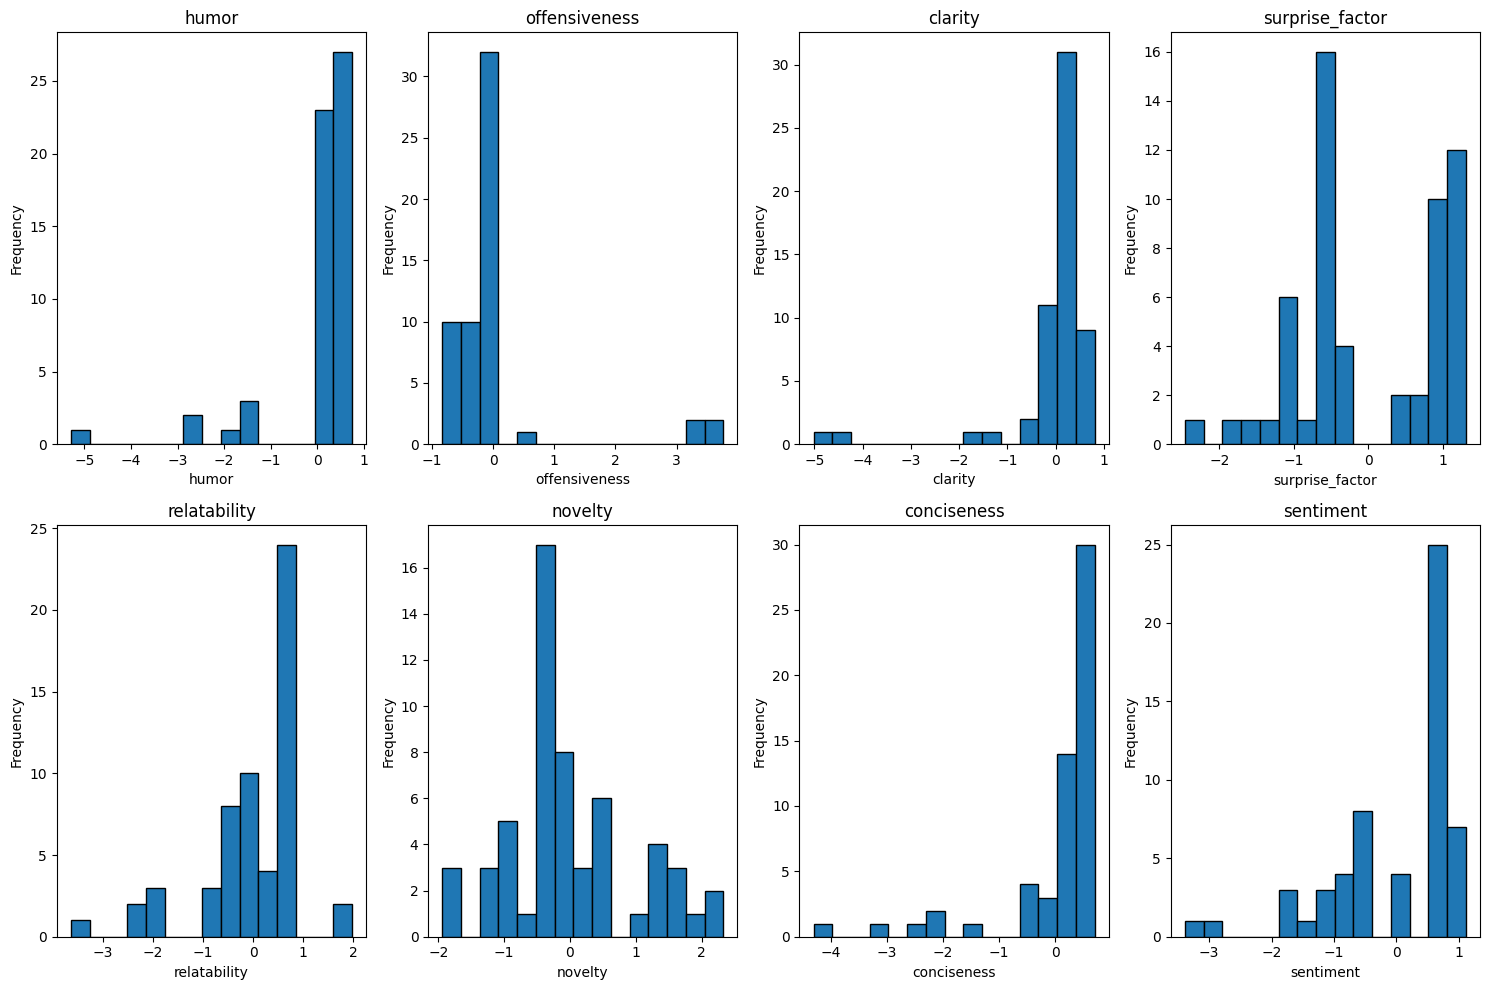

In [17]:
# Assuming you already have the DataFrame loaded as 'df'
# List of numerical columns to analyze
numeric_cols = [
    'humor', 
    'offensiveness', 
    'clarity', 
    'surprise_factor', 
    'relatability', 
    'novelty', 
    'conciseness', 
    'sentiment'
]

# 1. Calculate the 5-point summary for each numerical column.
# Using the describe() function with percentiles provides a good summary.
summary_stats = df[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75])
five_point_summary = summary_stats.loc[['min', '25%', '50%', '75%', 'max']]
print("5-Point Summary (Min, 25th, Median, 75th, Max):")
print(five_point_summary)

# 2. Extracting the Standard Deviation for each column.
std_devs = df[numeric_cols].std()
print("\nStandard Deviation:")
print(std_devs)

# 3. Plot the distribution for each numerical column
# Create a separate histogram for each column.
num_columns = len(numeric_cols)
plt.figure(figsize=(15, 10))
for idx, column in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, idx)  # Arrange subplots in a 2-row, 4-column grid.
    plt.hist(df[column].dropna(), bins=15, edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Chroma Analysis

Yearly Average Metrics:
            humor  offensiveness    clarity  surprise_factor  relatability  \
year                                                                         
2008.0  65.000000       5.000000  81.428571        58.571429     33.571429   
2009.0  61.008696       4.786957  81.956522        47.826087     25.239130   
2010.0  49.254762      18.583333  77.226190        53.502381     27.445238   
2011.0  51.718388      19.536524  76.241814        60.173048     26.984887   
2012.0  51.993622      19.907402  77.299764        61.251654     27.982835   
2013.0  53.572232      18.079294  78.456792        62.133453     28.348414   
2014.0  53.504558      16.967335  78.489395        61.477119     28.337527   
2015.0  53.639384      16.158337  78.790303        60.956154     28.452452   
2016.0  53.803289      16.109707  78.772588        61.566170     28.774724   
2017.0  55.820881      13.809369  80.130909        63.404325     30.149559   
2018.0  57.134982      12.626204  80.901

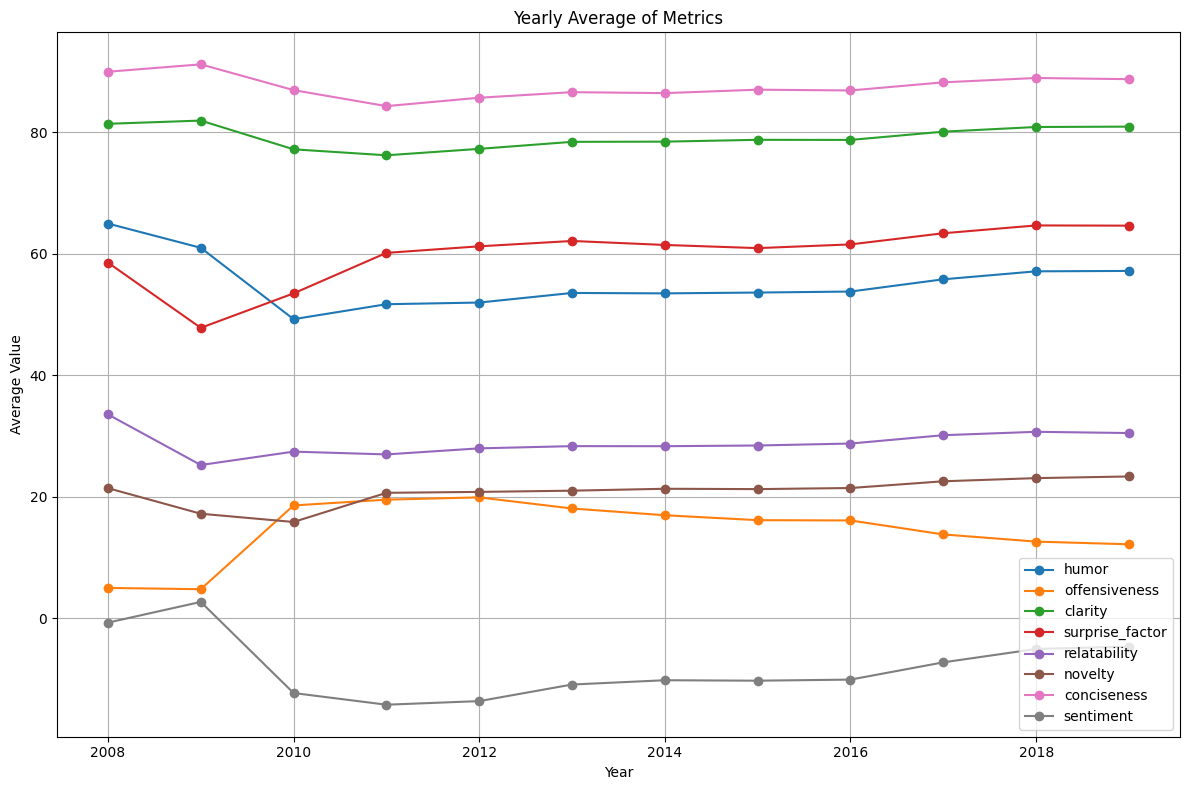

In [9]:
# Ensure that the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column and create a new 'year' column
df['year'] = df['date'].dt.year

# Define the numerical columns to analyze
numeric_cols = [
    'humor', 
    'offensiveness', 
    'clarity', 
    'surprise_factor', 
    'relatability', 
    'novelty', 
    'conciseness', 
    'sentiment'
]

# Group by year and calculate the mean for each metric
yearly_averages = df.groupby('year')[numeric_cols].mean()

# Print the yearly averages DataFrame
print("Yearly Average Metrics:")
print(yearly_averages)

# Plot each metric's yearly average on a single plot for comparison
plt.figure(figsize=(12, 8))
for metric in numeric_cols:
    plt.plot(yearly_averages.index, yearly_averages[metric], marker='o', linestyle='-', label=metric)

plt.title('Yearly Average of Metrics')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()